In [1]:
using OrdinaryDiffEq
using Plots
using Random
using Optim
using LaTeXStrings
using BenchmarkTools

rng = Xoshiro(14588); # set random number generator seed

In this notebook, we still consider the pendulum model $$\frac{\mathrm{d}}{\mathrm{d}t}x(t)=\begin{bmatrix}\dot{\theta}(t)\\ \ddot{\theta}(t)\end{bmatrix}=\begin{bmatrix}x_2(t)\\ -\frac{g}{L}\sin(x_1(t))-\frac{b}{m}x_2(t)\end{bmatrix}$$ but will estimate not only the unknown parameter $b$ but also the initial state $x_0$ from which the ground truth data was obtained.

In [2]:
# Model parameters defined as constants
const g = 9.81 # gravity constant
const L = 1.0 # length of pendulum
const b = 0.25 # damping coefficient
const m = 0.5 # mass of pendulum

#Initial condition and simulation time span
const x0 = [0,π/2]
const tspan = (0.0,4)

(0.0, 4)

In [3]:
#Define the ODE model as a function which can be passed to a solver
function simplependulum!(dx,x,p,t)
    dx[1] = x[2]
    dx[2] = -(g/L)*sin(x[1]) - b/m*x[2]
    nothing
end;

In [4]:
#Define ODE problem and solve
prob = ODEProblem(simplependulum!, x0, tspan);
sol = solve(prob,Tsit5(),saveat=0.05);


In [5]:
# add noise to States
t, x = sol.t, sol.u # get time and state vector
N = length(t)
σ = 0.05; # standard deviation of measurement noise
y = reduce(hcat,x) + σ*randn(2,N); # add noise to state vector


In [6]:
function simplependulum_train_friction!(dx,x,p,t)
    dx[1] = x[2]
    dx[2] = -(g/L)*sin(x[1]) - p[1]/m*x[2]
    nothing
end;

In [7]:
prob = ODEProblem(simplependulum_train_friction!, [0, 0], tspan, [1.0]);
function costs(w, y, f)
    newprob = remake(f; u0 = w[1:2], p = w[3]) # create an updated ODE problem with new parameters
    sol = solve(newprob,Tsit5(),saveat=0.05)
    x = reduce(hcat,sol.u)    
    return sum(abs2.(y .- x)) # return the sum of squared errors
end;

In contrast to previous notebook, we extend our optimization variable vector to not only inlude the unknown parameter $b$ but also the unknown initial state $x_0$.

In [8]:
res = optimize(w -> costs(w, y, prob), [0.0, 0.0, 1.0], Newton(); autodiff=:forward)

 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     4.369139e-01

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 3.37e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.15e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.43e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.47e-13 ≰ 0.0e+00
    |g(x)|                 = 1.29e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    8
    f(x) calls:    29
    ∇f(x) calls:   29
    ∇²f(x) calls:  8


In [15]:
# Print the found parameter result and compare to ground truth
println("Found initial conditions: ", round.(res.minimizer[1:2], digits = 4))
println("Ground truth: ",  round.(x0, digits = 4))
println("")
println("Found friction parameter: ", round.(res.minimizer[3], digits = 4))
println("Ground truth: ", b)

Found initial conditions: [0.0014, 1.5665]
Ground truth: [0.0, 1.5708]

Found friction parameter: 0.2417
Ground truth: 0.25


Finally, let's visualize the found results. 

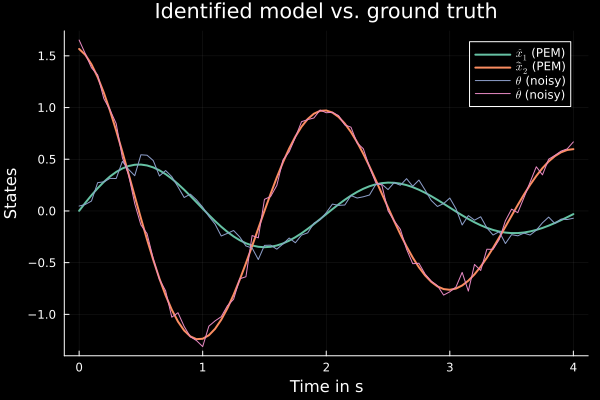

In [16]:
newprob = remake(prob, p = res.minimizer[3], u0 = res.minimizer[1:2])
sol = solve(newprob,Tsit5(),saveat=0.05)
x = reduce(hcat,sol.u)
plot(sol.t,x',label=[L"$\hat{x}_1$ (PEM)" L"$̂\hat{x}_2$ (PEM)"],xlabel="Time in s",
ylabel="States",title="Identified model vs. ground truth", lw=2,background_color="#000000", 
palette = :Set2_5)
plot!(sol.t,y',label=[L"$\theta$ (noisy)" L"$\dot{\theta}$ (noisy)"])